In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [3]:
import gym
import os
import sys
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning import plot_running_avg, FeatureTransformer

In [5]:
# so you can test different architectures
class HiddenLayer:
    def __init__(self, M1, M2, f= T.nnet.relu, use_bias= True, zeros= False):
        if zeros:
            W = np.zeros((M1, M2))
        else: 
            W = np.random.randn(M1, M2) / np.sqrt(M1+M2)

        self.W = theano.shared(W)
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = theano.shared(np.zeros(M2))
            self.params += [self.b]
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = X.dot(self.W) + self.b
        else:
            a = X.dot(self.W)
        return self.f(a)

In [16]:
# approximates pi(a | s)
class PolicyModel:
    def __init__(self, ft, D, hidden_layer_sizes_mean= [], hidden_layer_sizes_var= []):
        # starting learning rate and other hipermarameters
        lr = 10e-4
        mu = 0.7
        decay = 0.999
        
        # save inputs for copy
        self.ft = ft
        self.D = D
        self.hidden_layer_sizes_mean = hidden_layer_sizes_mean
        self.hidden_layer_sizes_var = hidden_layer_sizes_var
        
        ### model the mean ####
        self.mean_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_mean:
            layer = HiddenLayer(M1, M2)
            self.mean_layers.append(layer)
            M1 = M2
        
        # final layer
        layer = HiddenLayer(M1, 1, lambda x: x, use_bias = False, zeros = True)
        self.mean_layers.append(layer)
        
        ### model the variance ####
        self.var_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_var:
            layer = HiddenLayer(M1, M2)
            self.var_layers.append(layer)
            M1 = M2
        
        # final layer
        layer = HiddenLayer(M1, 1, T.nnet.softplus, use_bias = False, zeros = False)
        self.var_layers.append(layer)      
        
        # get all params for gradient later
        params = []
        for layer in (self.mean_layers + self.var_layers):
            params += layer.params
            
        velocities = [theano.shared(p.get_value()*0) for p in params]
        cache = [theano.shared(np.ones_like(p.get_value()*0.1)) for p in params]
        self.params = params
        
        # inputs and targets
        X = T.matrix('X')
        actions = T.vector('actions')
        advantages = T.vector('advantages')
        
        # calculate output and cost
        def get_output(layers):
            Z = X
            for layer in layers:
                Z = layer.forward(Z)
            return Z.flatten()
        
        mean = get_output(self.mean_layers)
        var = get_output(self.var_layers) + 10e-5 # smoothing
        
        # can't find Theano log pdf, we will make it
        def log_pdf(actions, mean, var):
            k1 = T.log(2*np.pi*var)
            k2 = (actions - mean)**2 / var
            return -0.5*(k1 + k2)
        
        log_probs = log_pdf(actions, mean, var)
        cost = -T.sum(advantages * log_probs + 0.1*T.log(2*np.pi*var)) + 1.0*mean.dot(mean)
        
        # specify update rule
        grads = T.grad(cost, params)
        g_update = [(p, p + v) for p, v, g in zip(params, velocities, grads)]
        c_update = [(c, decay * c + (1 - decay) * g*g) for c, g in zip(cache, grads)]
        v_update = [(v, mu*v - lr*g / T.sqrt(c)) for v, c, g in zip(velocities, cache, grads)]
        # momentum option
        # v_update = [(v, mu*v - lr*g) for v, g in zip(velocities, grads)]
        # c_update = []
        
        updates = c_update + g_update + v_update
        
        # compile functions
        self.train_op = theano.function(
            inputs = [X, actions, advantages],
            updates = updates,
            allow_input_downcast = True
        )
        
        self.predict_op = theano.function(
            inputs = [X],
            outputs = [mean, var],
            allow_input_downcast = True
        )
        
    
    def predict(self, X):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        return self.predict_op(X)
    
    def sample_action(self, X):
        pred = self.predict(X)
        mu = pred[0][0]
        v = pred[1][0]
        a = np.random.rand()*np.sqrt(v) + mu
        return min(max(a, -1), 1)
    
    def copy(self):
        clone = PolicyModel(self.ft, self.D, self.hidden_layer_sizes_mean, self.hidden_layer_sizes_var)
        clone.copy_from(self)
        return clone
    
    def copy_from(self, other):
        # self is being copied from other
        for p, q in zip(self.params, other.params):
            v = q.get_value()
            p.set_value(v)
            
    def perturb_params(self):
        for p in self.params:
            v = p.get_value()
            noise = np.random.rand(*v.shape) / np.sqrt(v.shape[0]) * 5.0
            if np.random.random() < 0.1:
                # with probability 0.1 start completely from scratch
                p.set_value(noise)
            else:
                p.set_value(v + noise)
    

In [20]:
def play_one(env, pmodel, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        # oddly, the mountain car environment requires th action to bi in
        # an object where the actual action is stored in object[0]
        observation, reward, done, info = env.step([action])
        
        totalreward += reward    
        iters +=1
    
    return totalreward

In [8]:
def play_multiple_episodes(env, T, pmodel, gamma, print_iters = False):
    totalrewards = np.empty(T)
    
    for i in range(T):
        totalrewards[i] = play_one(env, pmodel, gamma)
        
        if print_iters:
            print(i, "avg so far:", totalrewards[:(i+1)].mean())
            
    avg_totalrewards = totalrewards.mean()
    print("avg totalrewards:", avg_totalrewards)
    return avg_totalrewards

In [14]:
def random_search(env, pmodel, gamma):
    totalrewards = []
    best_avg_totalreward = float('-inf')
    best_pmodel = pmodel
    num_episodes_per_param_test = 3
    for t in range(100):
        tmp_pmodel = best_pmodel.copy()
        
        tmp_pmodel.perturb_params()
        
        avg_totalrewards = play_multiple_episodes(
            env,
            num_episodes_per_param_test,
            tmp_pmodel,
            gamma
        )
        totalrewards.append(avg_totalrewards)
        
        if avg_totalrewards > best_avg_totalreward:
            best_pmodel = tmp_pmodel
            best_avg_totalreward = avg_totalrewards
            
    return totalrewards, best_pmodel

In [10]:
def main():
    env = gym.make('MountainCarContinuous-v0')
    ft = FeatureTransformer(env, n_components= 100)
    D = ft.dimensions
    pmodel = PolicyModel(ft, D, [], [])
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
    
    totalrewards, pmodel = random_search(env, pmodel, gamma)
    print("max reward:", np.max(totalrewards))
    
    # play 100 episodes and check the average
    avg_totalrewards = play_multiple_episodes(env, 100, pmodel, gamma, print_iters= False)

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

avg totalrewards: 76.4869379489
avg totalrewards: 83.7190623522
avg totalrewards: 80.3935206457
avg totalrewards: 82.5454637775
avg totalrewards: 76.4029737195
avg totalrewards: 77.6129732229
avg totalrewards: 84.4245695677
avg totalrewards: 78.3746123058
avg totalrewards: 85.1588052564
avg totalrewards: 84.2597644787
avg totalrewards: 77.4399194049
avg totalrewards: 84.7687422309
avg totalrewards: 84.7318919606
avg totalrewards: 84.8597349025
avg totalrewards: 84.4970679848
avg totalrewards: 84.728703913
avg totalrewards: 85.3090921287
avg totalrewards: 88.8444063447
avg totalrewards: 84.9335471555
avg totalrewards: 88.2874788867
avg totalrewards: 85.5932406729
avg totalrewards: 85.1965373832
avg totalrewards: 89.7497802927
avg totalrewards: 87.4476062395
avg totalrewards: 87.6320776859
avg totalrewards: 88.1756952399
avg totalrewards: 85.5225224334
avg totalrewards: 88.5305138648
avg totalrewards: 88.2145006068
avg totalrewards: 87.6694133218
avg totalrewards: 88.3935624999
avg total

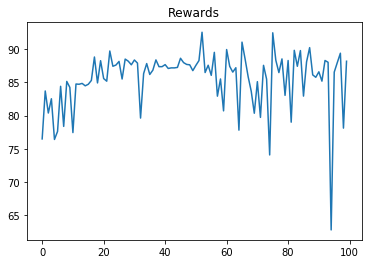

In [21]:
if __name__ == '__main__':
    main()